<a href="https://colab.research.google.com/github/teegwende/WQPandEntitiesDensity/blob/main/evaluationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [76]:
from pandas import read_csv, DataFrame
import pandas as pd
pd.set_option('display.float_format', '{:.3f}'.format)


######################################################## CHOIX DATASET #############################################################
jeu_donnees=int(input('1-jeu Panamasso 2-UCAD 3-Compaore'))
if jeu_donnees==1:
    df = read_csv('/gdrive/MyDrive/traitement_ordinaire/datarep/feed_new.csv', index_col='DATE', parse_dates=True)
    df=df.drop(columns=['entry_id','latitude','longitude','elevation','status'])
if jeu_donnees==2:
    df = read_csv('/gdrive/MyDrive/traitement_ordinaire/datarep/data_ucad.csv', index_col='DATE', parse_dates=True)

if jeu_donnees==3:
    df = read_csv('/gdrive/MyDrive/traitement_ordinaire/datarep/etude_de_compaore2 .csv', index_col='DATE', parse_dates=True)
    #df=df.drop(columns=['entry_id','latitude','longitude','elevation','status'])

######################################################"PREPROCESSING##################################################################
##########################################ELIMINATION VALEURS ABERRANTES##############################################################
#évaluation des plages des valeurs 
plage = {"PH":[0,14],
        "TEMP":[0,60]}
#dataparams = list()
dataparams={}  # Noter que l'algo est de créer un dico avec comme clé chaque param
for col in df.columns:
    if not plage.get(col)==None:
        sub=df.loc[ ~ (  (df[col]<=plage.get(col)[0])  | (df[col]>=plage.get(col)[1]) ) ][col]
        dataparams[col]=sub


####################################################DIFFRENTES FONCTIONS#########################################################
###############################################FONCTION IMPUTATION##############################################################
import numpy as np
import math 
from pandas import concat

def imputation(ledataframe):
    params=["PH","TEMP"]
    cols=list()
    for param in params:
        data=dataparams.get(param).resample('D').mean()
        i=0
        j=0
        for index, row in data.items():   
            if(i==data.size):
                break
            if math.isnan(data.iloc[i]):
                val1=data.iloc[i-1] #On stocke la premiere valeur de calcul de la moyenne
                j=i
                while math.isnan(data.iloc[j]): #on saute toutes les autres valeurs nan
                    j=j+1
                val2=data.iloc[j]
                k=i
                while k<j: #on remonte pour remplacer les valeurs nan par la moyenne
                    data.iloc[k]=(val1+val2)/2
                    k=k+1
                i=j #i redevient j pour qu'on continue avec les valeurs suivantes
            else:
                i=i+1
        cols.append(data)
    agg=concat(cols,axis=1)
    agg.columns=params
    return agg
  

###############################################FONCTION DIVISION DES DONNEES###########################################################
def diviserdata(periode,donnees):
  train,test=donnees.loc[donnees.index < periode],donnees.loc[donnees.index> periode]
  return train,test

train_PersoImput, test_PersoImput=diviserdata("06-2017",imputation(pd.DataFrame(dataparams).resample('D').mean()))
#train_PersoImput.loc[train_PersoImput.index == '01-2019'
#train_PersoImput.loc['01-2019'].head(2)

1-jeu Panamasso 2-UCAD 3-Compaore3


In [116]:
###############################################DIFFRENTES FONCTIONS SUITE########################################################
###############################################FONCTION NORMALISATION############################################################

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
scaler = MinMaxScaler(feature_range=(0, 1)) # instance de la classe MinMaxScaler
#scaler = StandardScaler() # instance de la classe MinMaxScaler
#scaler = RobustScaler() # instance de la classe MinMaxScaler
#Normalization process
def normaliser(donnees):
    resultat = scaler.fit_transform(donnees) #transformation du dataset via une méthode de l'instance de MinMaxScaler
    #test_temp = scaler.fit_transform(test_temp)
    return resultat

########################################FONCTION TRANSFORMATION FORMAT SUPERVISE#################################################
#Préparation des données à entrainer
#Transformation des series temporelles en jeu de donnees supervisee 
#times series vers cross-sectional data (c'est un peu les termes techniques)
from pandas import concat
def preparationData(donnees, nbValPrec=1, nbValSuiv=1,dropnan=True):
    #params=["ind0","ind1","DATE","PH","TEMP"]
    params=["DATE","PH","TEMP"]
    #params=["PH","TEMP"]
    n_vars = 1 if type(donnees) is list else donnees.shape[1]
    df = DataFrame(donnees)
    newdf=df.reset_index(drop=False)
    #print(newdf)
    cols, names = list(), list()
    #Les valeurs précédentes à considérer
    for i in range(nbValPrec, 0, -1):
        cols.append(newdf.shift(i))
        #param='TEMP'
        #names += [('temp%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        names += [(param+'(t-%d)' % (i)) for param in params ]
    #La longueur de prédiction
    for i in range(0, nbValSuiv):
        cols.append(newdf.shift(-i))
        if i == 0:
            #names += [('temp%d(t)' % (j+1)) for j in range(n_vars)]
            names += [(param+'(t)') for param in params ]
        else:
            #names += [('temp%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            names += [(param+'(t+%d)' % (i)) for param in params ]
    #Le dataset final
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

###############################################FONCTION COMPELTION DATA COEF WAVELET##########################################################
#Algo pour compléter un nombre pour obtenir le multiple de son diviseur
#Récupérer le reste de la division
#Soustraire le reste du coeficient
#additionner le resultat de la soustraction au nombre initial
# Import math Library
import math 
def completerData(donnees):
    level=3
    nombredezeros= int(math.pow(2,level))- ( len(donnees) % int(math.pow(2,level))   )
    pad_arr = np.pad(donnees, (0,nombredezeros), 'constant', constant_values=(0))
    return pad_arr

###############################################FONCTION FORMATION DATASET POUR WANN ##########################################################
#Elabaration du newinput
import pywt
from pandas import concat
def createnewinput(donnees,wavelet,level):
    newinput=list()
    for i in range(donnees.shape[1]):
        newdf=completerData(donnees[:, i]) #il complète le nombre de zéros nécessaires
        #coefswt=pywt.swt(newdf,'haar',level=3,norm=True,axis=0) #ici il calcule les coefficients
        coefswt=pywt.swt(newdf,wavelet,level=level,norm=True,axis=0) #ici il calcule les coefficients
        newinput.append(pd.Series(coefswt[0][0]))
        for coef in coefswt:
            newinput.append(pd.Series(coef[1]))
    agg=concat(newinput,axis=1)
    return agg

import keras
from keras.layers import Dense,Activation,Flatten
from keras.models import Sequential

from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

##############################################FONCTIONS DE VISUALISATION DES RESULTATS #############################################""
def visualPrediction(param,periode,donneestest,donneesPredite,nb_obs,horizon,nbrefois,directory):
  interval=1
  fig, ax = plt.subplots(figsize=(15, 6))
  ax.plot(pd.to_datetime(periode),donneestest,'o-',label='Donnees Test')
  
  for v,p in zip(donneestest,periode):
    if interval==30 or interval==60 or interval==84:
      ax.annotate(round(v,2),xy=(p,v),fontsize=10)
    interval=interval+1

  ax.plot(pd.to_datetime(periode),donneesPredite,'o-',label='Donnes Predites')

  interval=1

  for v,p in zip(donneesPredite,periode):
    if interval==30 or interval==60 or interval==84:
      ax.annotate(round(v,2),xy=(p,v),fontsize=10)
    interval=interval+1

  ax.set(xlabel="Date", ylabel=param,
       title="WANN"+" "+param+" Lag"+str(nb_obs)+" Horizon="+str(horizon))
  ax.legend()

  # Format the x axis
  ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
  #ax.xaxis.set_major_locator(mdates.DayLocator(30))
  #ax.xaxis.set_major_locator(mdates.MonthLocator())
  ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
  plt.xticks(rotation=45, ha='right',fontsize=14)
  #plt.xlim(periode[0],periode[20])
  plt.savefig(directory+"WANN"+'_'+str(nb_obs)+'_'+str(horizon)+'_Nb'+str(nbrefois)+param+'.pdf')

  plt.show()
  plt.close()

####Noter que dans cette fonction, on peut juste retenir la dernière colonne de l'horizon recherché
###Tout comme on peut plotter toutes les valeurs prédites de depuis parm (t) jusqu'à parm(t-+horzion-1)
def visualCalibrationPlot(param,donneestest,donneesPredite,nbrefois,directory,periode):
 
  plt.figure(figsize=(15,6))
  #plt.plot(donneestest[-len(periode):],donneestest[-len(periode):],c='black')
  #plt.scatter(donneestest[-len(periode):],donneesPredite[-len(periode):],c='blue',alpha=0.6)
  plt.plot(donneestest,donneestest,c='black')
  plt.scatter(donneestest,donneesPredite,c='blue',alpha=0.6)
  plt.xlabel(param+" Attendue")
  plt.ylabel(param+" Prédite")
  plt.savefig(directory+"WANN"+'_'+str(nb_obs)+'_'+str(horizon)+'_Nb'+str(nbrefois)+param+'.pdf')
  plt.show()
  plt.legend(loc=0)
  plt.close()

In [117]:
mesdata=preparationData(train_PersoImput,10,84)
mesdata.loc[:,mesdata.columns.str.contains("DATE\(t\-|DATE\(t\)")].loc[214:214:,]
#mesdata.loc[53:53,]

,DATE(t-10),DATE(t-9),DATE(t-8),DATE(t-7),DATE(t-6),DATE(t-5),DATE(t-4),DATE(t-3),DATE(t-2),DATE(t-1),DATE(t)
214,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,2017-01-01


In [118]:
donnees_train=train_PersoImput 
donnees_test=test_PersoImput
nb_obs=10
horizon=84
n_features=2

wavelet="haar"
level=3

train=preparationData(donnees_train,nb_obs,horizon)

train_dates=train.loc[:, train.columns.str.contains("DATE\(t\+|DATE\(t\)")]
train=train.loc[:,~train.columns.str.contains("DATE")]

#ligne=273 #Correspond aux 10 derniers jours du mois de février donc saison froide
ligne= 214# Correspond aux 10 derniers jours de décembre, donc saison froide. Mieux adapté car la période de collecte était Décembre. 
          # Les prédictions doivent nous conduire vers le mois de janvier février Mars. C'est Mars qui nous intéresse (correspond à la période chaude)
test2=train.loc[ligne:ligne:,]
test_dates2=train_dates.loc[ligne:ligne:,]

print("dates =",test_dates2)
#Subdivision en X et y

X_test2,y_test2 = test2.iloc[:,:nb_obs*n_features].values,test2.iloc[:, -horizon*n_features:].values
print("X_test2",X_test2)


X_test2=normaliser(X_test2)
y_test2=normaliser(y_test2)


print("X_test2 normaliser",X_test2)
X_test2=createnewinput(X_test2,wavelet,level)
X_test2=X_test2.values

print("y_test2",y_test2)

dates =        DATE(t)  DATE(t+1)  DATE(t+2)  DATE(t+3)  DATE(t+4)  DATE(t+5)  \
214 2017-01-01 2017-01-02 2017-01-03 2017-01-04 2017-01-05 2017-01-06   

     DATE(t+6)  DATE(t+7)  DATE(t+8)  DATE(t+9)  ... DATE(t+74) DATE(t+75)  \
214 2017-01-07 2017-01-08 2017-01-09 2017-01-10  ... 2017-03-16 2017-03-17   

    DATE(t+76) DATE(t+77) DATE(t+78) DATE(t+79) DATE(t+80) DATE(t+81)  \
214 2017-03-18 2017-03-19 2017-03-20 2017-03-21 2017-03-22 2017-03-23   

    DATE(t+82) DATE(t+83)  
214 2017-03-24 2017-03-25  

[1 rows x 84 columns]
X_test2 [[ 7. 24.  7. 24.  7. 24.  7. 24.  7. 24.  7. 24.  7. 24.  7. 24.  7. 24.
   7. 24.]]
X_test2 normaliser [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
y_test2 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [119]:
#cheminmodel='21_Jun_2022_11_30/WANN_nbObs2_H1/
#cheminmodel='22_Jun_2022_23_02/WANN_nbObs4_H7/'
#cheminmodel='23_Jun_2022_10_50/WANN_nbObs4_H14/'
# cheminmodel='23_Jun_2022_12_06/WANN_nbObs4_H28/'
#cheminmodel='23_Jun_2022_12_37/WANN_nbObs4_H84/'
cheminmodel='07_Jul_2022_13_05/WANN_nbObs10_H84/'
model = keras.models.load_model('/gdrive/MyDrive/traitement_ordinaire/'+cheminmodel)
predictions=model.predict(X_test2[:len(y_test2)])

In [120]:
predictions

array([[ 0.10888247, -0.00423779,  0.11091255,  0.03831513,  0.1984414 ,
         0.02336251,  0.17376728,  0.00353657,  0.20144808,  0.02067382,
         0.18445164, -0.03461551,  0.16302273,  0.00517029,  0.19250178,
        -0.02922228,  0.1863093 ,  0.011007  ,  0.19212039,  0.01206988,
         0.17236017, -0.00471238,  0.24957936, -0.01579834,  0.20483927,
         0.01468447,  0.24669425,  0.01257508,  0.19888276, -0.02445809,
         0.22284858,  0.03361918,  0.28243354, -0.03823106,  0.24228081,
        -0.02176744,  0.24303114,  0.02055529,  0.27724278, -0.01552059,
         0.27303228, -0.07054346,  0.23276222, -0.01409501,  0.30007428,
        -0.00234521,  0.26472148, -0.04494117,  0.2647925 , -0.01093367,
         0.25691366, -0.05840804,  0.2411066 , -0.02938756,  0.29191676,
        -0.02355933,  0.26564404, -0.03607548,  0.27215558, -0.01718493,
         0.29801497,  0.00208355,  0.3033285 , -0.03532369,  0.28981313,
        -0.04518551,  0.2928813 ,  0.01171728,  0.2

In [121]:
predictions=scaler.inverse_transform(predictions) 
y_test2=scaler.inverse_transform(y_test2)
print(predictions)
print(y_test2)

[[ 7.1088824 23.995762   7.1109123 24.038315   7.1984415 24.023363
   7.173767  24.003536   7.201448  24.020674   7.1844516 23.965385
   7.1630225 24.00517    7.192502  23.970778   7.1863093 24.011007
   7.1921206 24.01207    7.17236   23.995287   7.2495794 23.984201
   7.204839  24.014685   7.246694  24.012575   7.1988826 23.975542
   7.2228484 24.033619   7.2824335 23.96177    7.242281  23.978233
   7.243031  24.020555   7.2772427 23.98448    7.273032  23.929457
   7.2327623 23.985905   7.300074  23.997654   7.2647214 23.95506
   7.2647924 23.989067   7.2569137 23.941591   7.2411065 23.970612
   7.291917  23.97644    7.265644  23.963924   7.272156  23.982815
   7.298015  24.002083   7.3033285 23.964676   7.289813  23.954815
   7.2928815 24.011717   7.2864995 23.937992   7.2546825 23.989504
   7.305222  23.980787   7.3170557 23.991573   7.3234496 23.95868
   7.3168607 23.960798   7.3353786 23.96235    7.331893  23.947363
   7.362225  23.997444   7.2690315 23.985634   7.3264713 24.0351

y_test2 (1, 168)
                0
2017-01-01 23.990
2017-01-31 24.095
2017-03-02 27.092


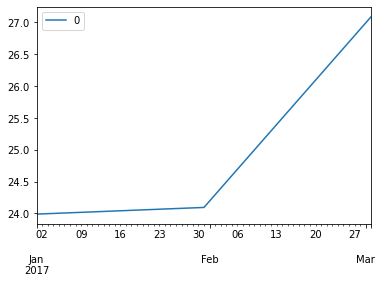

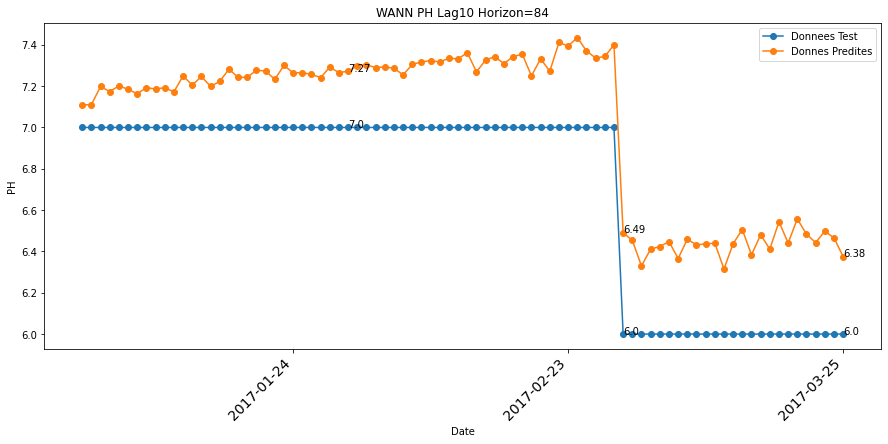

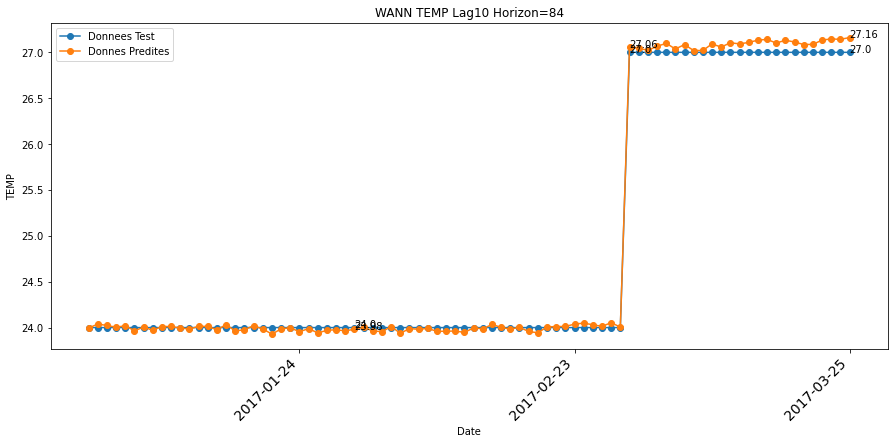

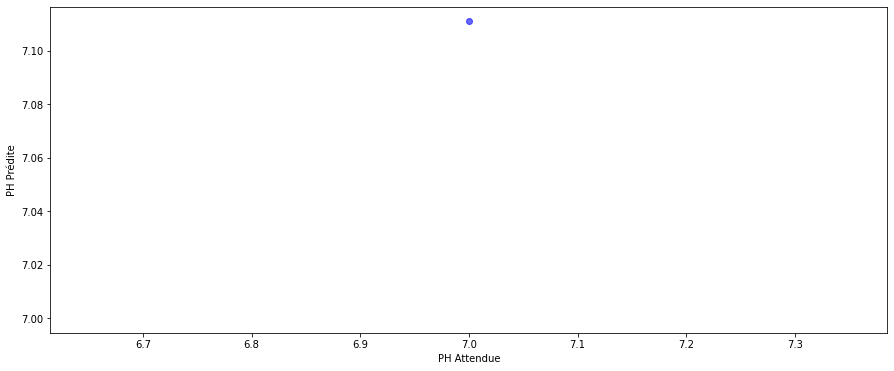

No handles with labels found to put in legend.


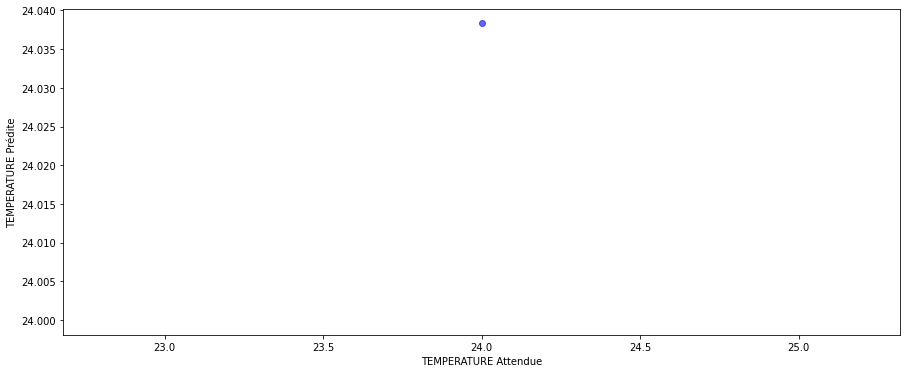

No handles with labels found to put in legend.


In [122]:
import os
from datetime import datetime, timedelta

nbrefois=1
#Création du dossier des graphes
now = datetime.now()
directory=str('/gdrive/MyDrive/traitement_ordinaire/' +str( now.strftime(("%d_%b_%Y_%H_%M")) ) )
if not os.path.exists(directory):
    os.mkdir(directory)

predictions=pd.DataFrame(predictions)
y_test2=pd.DataFrame(y_test2)
      
predictionPH=pd.DataFrame()
y_testPH=pd.DataFrame()
predictionTemp=pd.DataFrame()
y_testTemp=pd.DataFrame()

if horizon==1:
  lesdates= test_dates2.loc[:, test_dates2.columns.str.contains("DATE\(t\)")]
else:
  #lesdates= test_dates2.loc[:, test_dates2.columns.str.contains("DATE\(t\+"+str(horizon-1)+"\)")] 
  lesdates= test_dates2.loc[:, test_dates2.columns.str.contains("DATE\(t\+|DATE\(t\)")] 


print("y_test2",y_test2.shape)

for ii in range( y_test2.shape[1]):
  if ii%2==0: #Pour séparer les températures des ph
    predictionPH=pd.concat([predictionPH, predictions.iloc[:,ii]],axis=1)
    y_testPH=pd.concat([y_testPH, y_test2.iloc[:,ii]],axis=1)
  else:
    predictionTemp=pd.concat([predictionTemp, predictions.iloc[:,ii]],axis=1)
    y_testTemp=pd.concat([y_testTemp, y_test2.iloc[:,ii]],axis=1)


testdf=pd.DataFrame(predictionTemp.values.reshape(-1),index=lesdates.values.reshape(-1))
print(testdf.resample('30D').mean())
testdf.resample('30D').mean().plot()

directoryPredict=directory+"/PredictionPlot/"
if not os.path.exists(directoryPredict):
  os.mkdir(directoryPredict)

# visualPrediction("PH",lesdates.values.reshape(-1) ,y_testPH.iloc[:,horizon-1].values.reshape(-1),predictionPH.iloc[:,horizon-1].values.reshape(-1),
#                  nb_obs,horizon,nbrefois,directoryPredict)
# visualPrediction("TEMP",lesdates.values.reshape(-1) ,y_testTemp.iloc[:,horizon-1].values.reshape(-1),predictionTemp.iloc[:,horizon-1].values.reshape(-1),
# nb_obs,horizon,nbrefois,directoryPredict)

visualPrediction("PH",lesdates.values.reshape(-1) ,y_testPH.values.reshape(-1),predictionPH.values.reshape(-1),
                  nb_obs,horizon,nbrefois,directoryPredict)
visualPrediction("TEMP",lesdates.values.reshape(-1) ,y_testTemp.values.reshape(-1),predictionTemp.values.reshape(-1),
nb_obs,horizon,nbrefois,directoryPredict)

        
directoryCalibration=directory+"/CalibrationPlot/"
if not os.path.exists(directoryCalibration):
  os.mkdir(directoryCalibration)

visualCalibrationPlot("PH",y_testPH.values.reshape(-1)[len(y_test2)],predictionPH.values.reshape(-1)[len(y_test2)],nbrefois,directoryCalibration,lesdates.values.reshape(-1)[len(y_test2)])
visualCalibrationPlot("TEMPERATURE",y_testTemp.values.reshape(-1)[len(y_test2)],predictionTemp.values.reshape(-1)[len(y_test2)],nbrefois,directoryCalibration,lesdates.values.reshape(-1)[len(y_test2)])

In [ ]:
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error, r2_score
from math import sqrt 

#Calcul des métriques
rmse = sqrt(mean_squared_error(predictions, y_test2))
mae = mean_absolute_error(predictions, y_test2)
r2=r2_score(predictions, y_test2)
print("rmse=",rmse)
print("mae=",mae)
print("r2=",r2)


rmse= 0.24395752600896087
mae= 0.18435982863108316
r2= nan


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
